In [30]:
import sys
sys.path.append("../src")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from exact_solution import solve_master_equation, one_excited_emitter_state

In [31]:
aqt_results = pd.read_csv("../data/AQT/QMarina-AQT-4Q.csv", index_col=0)
aqt_results = aqt_results.set_index(["Time", "Protocol", "Randomizations", "Identities"])

# renormalize naive data in the 1-excitation subspace; average emitter 2 and 3
aqt_raw = aqt_results.xs("RAW", level="Protocol")
raw_data_norm = aqt_raw.copy()
raw_data_norm[['1000', '0100', '0010', '0001']] = raw_data_norm[['1000', '0100', '0010', '0001']].divide(raw_data_norm[['1000', '0100', '0010', '0001']].sum(axis=1), axis=0)
raw_data_norm['avg_0100_0001'] = raw_data_norm[['0100', '0001']].mean(axis=1)

# renormalize rc data in the 1-excitation subspace; average emitter 2 and 3
rc_data = aqt_results.xs("RC", level="Protocol")
rc_data_norm = rc_data.copy()
rc_data_norm[['1000', '0100', '0010', '0001']] = rc_data_norm[['1000', '0100', '0010', '0001']].divide(rc_data_norm[['1000', '0100', '0010', '0001']].sum(axis=1), axis=0)
rc_data_norm['avg_0100_0001'] = rc_data_norm[['0100', '0001']].mean(axis=1)

aqt_times = rc_data.index.get_level_values("Time").unique()

aqt_bitstrs = {
    "Emitter 1": "1000",
    "Emitter 2": "0100",
    "Emitter 3": "0001",
    "Cavity + Environment": "0010",
}

normed_bitstrs = {
    "Emitter 1": "1000",
    "Emitter 2 and 3": "avg_0100_0001",
    "Cavity + Environment": "0010",
}

40 0.25160293223613744
80 0.2537392288851829


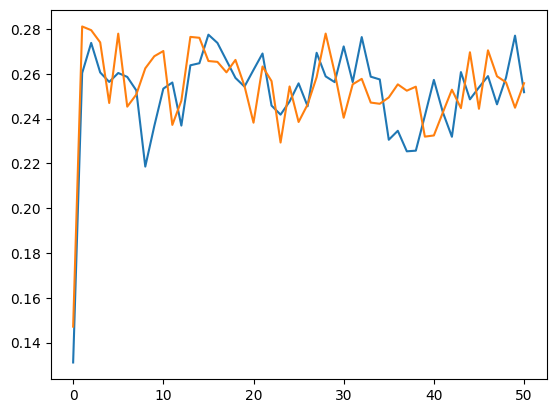

In [32]:
for n_rand in [40, 80]:
    data = rc_data.xs(n_rand, level="Randomizations")
    data = 1 - data[['1000', '0100', '0010', '0001']].sum(axis=1)
    plt.plot(data.tolist(), label=n_rand)
    print(n_rand, data.mean())

In [33]:
N = 3
g = 4
kappa = 2
times = np.linspace(0, 3, 51)

In [34]:
initial_state = one_excited_emitter_state(N, 1)
qutip_results = solve_master_equation(N, g, kappa, initial_state, times)

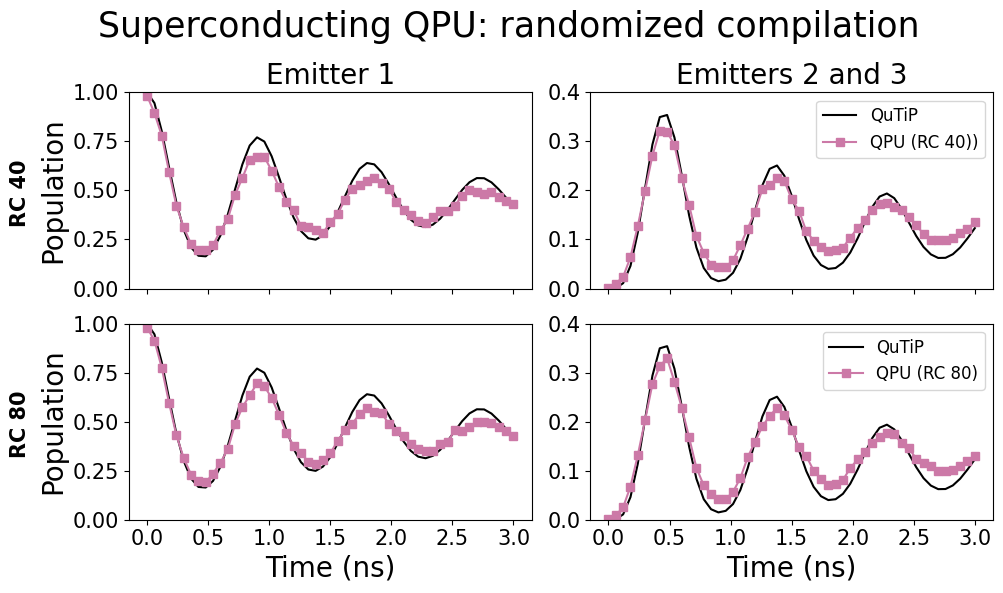

In [35]:
# Plot the RC data
fig, axes = plt.subplots(2, 2, figsize=(10, 6), sharex=True)

rc_40 = rc_data_norm.xs(40, level="Randomizations")
rc_80 = rc_data_norm.xs(80, level="Randomizations")


## RC 40

axes[0,0].set_title("Emitter 1", fontsize=20)
axes[0,0].plot(times, qutip_results["Emitter 1"], label="QuTiP", color='black')
axes[0,0].plot(aqt_times, rc_40[normed_bitstrs["Emitter 1"]], marker='s', label="QPU (RC 40)", color="#cc79a7")
axes[0,0].set_ylabel("Population", fontsize=20)
axes[0,0].set_ylim(0, 1)
axes[0,0].tick_params(axis='y', labelsize=15)

axes[1,0].set_ylim(0, 0.45)
axes[1,0].plot(times, qutip_results["Emitter 1"], label="QuTiP", color='black')
axes[1,0].plot(aqt_times, rc_80[normed_bitstrs["Emitter 1"]], marker='s', label="QPU (RC 80)", color="#cc79a7")
axes[1,0].set_ylabel("Population", fontsize=20)
axes[1,0].set_ylim(0, 1)
axes[1,0].tick_params(axis='y', labelsize=15)
axes[1,0].tick_params(axis='x', labelsize=15)

axes[1,0].set_xlabel("Time (ns)", fontsize=20)

axes[0,0].text(-0.27, 0.66, "RC 40", transform=axes[0,0].transAxes, weight='bold',
        ha='center', va='top', fontsize=15, rotation=90)


## RC 80

axes[0,1].set_ylim(0, 0.4)
axes[0,1].set_title("Emitters 2 and 3", fontsize=20)
axes[0,1].plot(times, qutip_results["Emitter 2"], label="QuTiP", color='black')
axes[0,1].plot(aqt_times, rc_40[normed_bitstrs["Emitter 2 and 3"]], marker='s', label="QPU (RC 40))", color="#cc79a7")
axes[0,1].legend(fontsize=12)
axes[0,1].tick_params(axis='y', labelsize=15)

axes[1,1].set_ylim(0, 0.4)
axes[1,1].plot(times, qutip_results["Emitter 2"], label="QuTiP", color='black')
axes[1,1].plot(aqt_times, rc_80[normed_bitstrs["Emitter 2 and 3"]], marker='s', label="QPU (RC 80)", color="#cc79a7")
axes[1,1].legend(fontsize=12)
axes[1,1].tick_params(axis='y', labelsize=15)
axes[1,1].tick_params(axis='x', labelsize=15)
axes[1,1].set_xlabel("Time (ns)", fontsize=20)

axes[1,0].text(-0.27, 0.66, "RC 80", transform=axes[1,0].transAxes, weight='bold',
        ha='center', va='top', fontsize=15, rotation=90)

fig.suptitle("Superconducting QPU: randomized compilation", fontsize=25)
plt.tight_layout()

In [36]:
fig.savefig("../figures/AQT_RC.eps", bbox_inches="tight")

In [37]:
from errorbars import calculate_mae_uncertainty, write_results_to_file

for num_rc in [40, 80]:
    for part1, part2 in zip(["Emitter 1", "Emitter 2"], ["Emitter 1", "Emitter 2 and 3"]):
        rc_postselected = rc_data_norm.xs(num_rc, level="Randomizations")
        rc_non_postselected = rc_data.xs(num_rc, level="Randomizations")

        #######  MAE for the postselected data

        exp = rc_postselected[normed_bitstrs["Emitter 1"]]
        thy = qutip_results["Emitter 1"]
        results = calculate_mae_uncertainty(exp, thy)
        write_results_to_file(results, processor="AQT", emitter="Emitter 1", condition=f"RC {num_rc} (postselected)")

        #######

        exp = rc_postselected["avg_0100_0001"]
        thy = qutip_results["Emitter 2"]
        results = calculate_mae_uncertainty(exp, thy)
        write_results_to_file(results, processor="AQT", emitter="Emitter 2", condition=f"RC {num_rc} (postselected)")


        #######  MAE for the NON-postselected data

        exp = rc_non_postselected[normed_bitstrs["Emitter 1"]]
        thy = qutip_results["Emitter 1"]
        results = calculate_mae_uncertainty(exp, thy)
        write_results_to_file(results, processor="AQT", emitter="Emitter 1", condition=f"RC {num_rc} (non-postselected)")

        #######

        exp = (rc_non_postselected["0100"] + rc_non_postselected["0001"]) / 2
        thy = qutip_results["Emitter 2"]
        results = calculate_mae_uncertainty(exp, thy)
        write_results_to_file(results, processor="AQT", emitter="Emitter 2", condition=f"RC {num_rc} (non-postselected)")

        # exp = rc_non_postselected["0001"]
        # thy = qutip_results["Emitter 3"]
        # results = calculate_mae_uncertainty(exp, thy)
        # write_results_to_file(results, processor="AQT", emitter="Emitter 3", condition=f"RC {num_rc} (non-postselected)")